In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
def parse_log_line(line: str) -> dict:
    # Extract timestamp
    timestamp_match = re.search(r"\[(.*?)\]", line)
    timestamp = timestamp_match.group(1) if timestamp_match else ""

    # Extract time elapsed
    time_elapsed_match = re.search(r"\((.*?)\)", line)
    time_elapsed = time_elapsed_match.group(1) if time_elapsed_match else ""

    # Extract host name and event name
    parts = line.split()
    host_name = parts[2] if len(parts) > 2 else ""
    event_name = parts[3].rstrip(":") if len(parts) > 3 else ""

    # Extract all {...} blocks
    curly_groups = re.findall(r"\{(.*?)\}", line)

    # Initialize fields
    cpu_id = "0"
    process_details = ""
    kernel_details = ""

    # Extract CPU ID from first group (if present)
    if len(curly_groups) >= 1:
        cpu_match = re.search(r"cpu_id\s*=\s*(\d+)", curly_groups[0])
        cpu_id = cpu_match.group(1) if cpu_match else "0"

    # Clean and assign process/kernel details (remove quotes)
    if len(curly_groups) >= 2:
        process_details = curly_groups[1].replace('"', '').replace("'", "").strip()
    if len(curly_groups) >= 3:
        kernel_details = curly_groups[2].replace('"', '').replace("'", "").strip()

    # Build formatted example string and escape all curly braces for PromptTemplate
    formatted = (
        f"timestamp:{timestamp}, time elapsed: (+{time_elapsed}), Host Name: {host_name}, "
        f"Event Name: {event_name}, Cpu Id: {cpu_id}, process_details: {process_details}, "
        f"kernel_details: {kernel_details}"
    )

    # Escape all braces for safe PromptTemplate use
    escaped_formatted = formatted.replace("{", "{{").replace("}", "}}")

    return {"example": escaped_formatted}

In [3]:
logs = []
with open("kernel_trace_100K.txt", "r") as file:
    for line in file:
        if line.strip():
            try:
                parsed = parse_log_line(line.strip())
                logs.append(parsed)
            except Exception as e:
                print(f"Error parsing line: {line}\n{e}")

In [4]:
logs

[{'example': 'timestamp:06:13:02.227908688, time elapsed: (++?.?????????), Host Name: mendax, Event Name: syscall_entry_accept, Cpu Id: 2, process_details: procname = elasticsearch[m, pid = 11822, tid = 11859, kernel_details: fd = 553, upeer_addrlen = 246916502706640'},
 {'example': 'timestamp:06:13:02.227912438, time elapsed: (++0.000003750), Host Name: mendax, Event Name: syscall_exit_accept, Cpu Id: 2, process_details: procname = elasticsearch[m, pid = 11822, tid = 11859, kernel_details: ret = 576, upeer_sockaddr = 246916502706648, upeer_addrlen = 246916502706640'},
 {'example': 'timestamp:06:13:02.227914646, time elapsed: (++0.000002208), Host Name: mendax, Event Name: syscall_entry_fcntl, Cpu Id: 2, process_details: procname = elasticsearch[m, pid = 11822, tid = 11859, kernel_details: fd = 576, cmd = 3, arg = 50'},
 {'example': 'timestamp:06:13:02.227914980, time elapsed: (++0.000000334), Host Name: mendax, Event Name: syscall_exit_fcntl, Cpu Id: 2, process_details: procname = ela

In [6]:
import pandas as pd
import re

def parse_key_value_block(block):
    """
    Parse a block like 'key1 = val1, key2 = val2' into a dictionary.
    Handles quoted values and removes extra whitespace.
    """
    pattern = re.findall(r'(\w+)\s*=\s*("[^"]*"|[^,]+)', block)
    return {
      key: re.sub(r"\[.*", "", val.strip('"').strip()) if key == "procname" else val.strip('"').strip()
      for key, val in pattern
  }

def parse_lttng_logs(file_path):
    log_pattern = re.compile(
        r"\[(?P<timestamp>[\d:.]+)\] "
        r"\(\+(?P<time_elapsed>[\d.?\?]+)\) "
        r"(?P<host_name>[\w\-.]+) "
        r"(?P<event_name>[\w_]+): "
        r"\{ cpu_id = (?P<cpu_id>\d+) \}, "
        r"\{ (?P<process_details>.*?) \}, "
        r"\{ (?P<kernel_details>.*?) \}"
    )

    records = []

    with open(file_path, 'r') as file:
        for line in file:
            match = log_pattern.match(line.strip())
            if match:
                base = match.groupdict()

                # Flatten process and kernel details
                process_fields = parse_key_value_block(base.pop("process_details"))
                kernel_fields = parse_key_value_block(base.pop("kernel_details"))

                # Combine all fields
                combined = {**base, **process_fields, **kernel_fields}
                records.append(combined)

    return pd.DataFrame(records)

file_path = "kernel_trace_100K.txt"
real_data = parse_lttng_logs(file_path)

In [7]:
real_data

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,arg5,vec,vlen,which,value,ovalue,uname,length,utx,name
0,06:13:02.227908688,?.?????????,mendax,syscall_entry_accept,2,elasticsearch,11822,11859,553,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearch,11822,11859,NaN,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearch,11822,11859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99241,06:13:09.322503258,0.000001334,mendax,syscall_exit_epoll_pwait,1,Mutter Input Th,3154,3269,1141642032,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99242,06:13:09.322504341,0.000001083,mendax,syscall_entry_read,1,Mutter Input Th,3154,3269,27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99243,06:13:09.322506008,0.000001667,mendax,syscall_exit_read,1,Mutter Input Th,3154,3269,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99244,06:13:09.322507716,0.000001708,mendax,syscall_entry_read,1,Mutter Input Th,3154,3269,27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
lstm = real_data.copy(deep=True)

In [9]:
lstm.at[0, 'time_elapsed'] = "0.000003735"

In [10]:
lstm.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,arg5,vec,vlen,which,value,ovalue,uname,length,utx,name
0,06:13:02.227908688,0.000003735,mendax,syscall_entry_accept,2,elasticsearch,11822,11859,553,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearch,11822,11859,NaN,246916502706640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearch,11822,11859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearch,11822,11859,576,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
lstm.to_csv("100K_logs_formatted.csv", index=False)
print("Data exported to 100K_logs_formatted.csv")

Data exported to 100K_logs_formatted.csv


In [151]:
# Numerical columns
numerical_cols = [
    'cpu_id', 'pid', 'tid', 'fd',
    'upeer_addrlen', 'ret', 'upeer_sockaddr', 'cmd', 'arg', 'usockaddr_len',
    'usockaddr', 'level', 'optname', 'optval', 'optlen', 'buf', 'count', 'epfd', 'maxevents', 'timeout', 'sigmask',
    'sigsetsize', 'sig', 'act', 'oact', 'tsp', 'nfds', 'fds_length', 'overflow', 'raw_events', 'POLLPRI', 'POLLOUT',
    'POLLERR', 'POLLHUP', 'padding', 'uaddr', 'op', 'val', 'utime', 'uaddr2', 'val3', 'brk', 'flags', 'addr', 'len', 'buff',
    'addr_len', 'size', 'ubuf', 'msg', 'offset', 'nbytes', 'advice', 'ufd', 'utmr', 'otmr'
]

categorical_cols = [
    'timestamp', 'host_name', 'event_name', 'procname', 'fds', 'events', 'op_enum', 'event'
]

for col in numerical_cols:
    if col in lstm.columns:
        try:
            lstm[col] = pd.to_numeric(lstm[col], errors='coerce').astype('Int64')
            print(f"{col} converted to Int64")
        except Exception as e:
            print(f"{col} could not be fully converted: {e}")
    else:
        print(f"{col} not found in DataFrame")

lstm['time_elapsed'] = pd.to_numeric(lstm['time_elapsed'], errors='coerce').astype('float64')

cpu_id converted to Int64
pid converted to Int64
tid converted to Int64
fd converted to Int64
upeer_addrlen converted to Int64
ret converted to Int64
upeer_sockaddr converted to Int64
cmd converted to Int64
arg converted to Int64
usockaddr_len converted to Int64
usockaddr converted to Int64
level converted to Int64
optname converted to Int64
optval converted to Int64
optlen converted to Int64
buf converted to Int64
count converted to Int64
epfd converted to Int64
maxevents converted to Int64
timeout converted to Int64
sigmask converted to Int64
sigsetsize converted to Int64
sig converted to Int64
act converted to Int64
oact converted to Int64
tsp converted to Int64
nfds converted to Int64
fds_length converted to Int64
overflow converted to Int64
raw_events converted to Int64
POLLPRI converted to Int64
POLLOUT converted to Int64
POLLERR converted to Int64
POLLHUP converted to Int64
padding converted to Int64
uaddr converted to Int64
op converted to Int64
val converted to Int64
utime con

In [152]:
lstm.dtypes

,0
timestamp,object
time_elapsed,float64
host_name,object
event_name,object
cpu_id,Int64
...,...
nbytes,Int64
advice,Int64
ufd,Int64
utmr,Int64


In [153]:
categorical_columns = lstm.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_columns)

['timestamp', 'host_name', 'event_name', 'procname', 'fds', 'events', 'op_enum', 'event']


In [154]:
lstm[categorical_cols] = lstm[categorical_cols].fillna('missing')

In [155]:
lstm[numerical_cols] = lstm[numerical_cols].fillna(-1)

In [156]:
lstm.head(1000)

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,ubuf,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr
0,06:13:02.227908688,3.735000e-06,mendax,syscall_entry_accept,2,elasticsearch,11822,11859,553,246916502706640,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1
1,06:13:02.227912438,3.750000e-06,mendax,syscall_exit_accept,2,elasticsearch,11822,11859,-1,246916502706640,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1
2,06:13:02.227914646,2.208000e-06,mendax,syscall_entry_fcntl,2,elasticsearch,11822,11859,576,-1,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1
3,06:13:02.227914980,3.340000e-07,mendax,syscall_exit_fcntl,2,elasticsearch,11822,11859,-1,-1,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1
4,06:13:02.227916313,1.333000e-06,mendax,syscall_entry_getsockname,2,elasticsearch,11822,11859,576,-1,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,06:13:02.232285404,2.500000e-07,mendax,syscall_exit_sync_file_range,0,lttng-consumerd,14323,14330,-1,-1,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1
966,06:13:02.232285613,2.090000e-07,mendax,syscall_entry_fadvise64_64,0,lttng-consumerd,14323,14330,35,-1,...,-1,missing,missing,-1,143360,-1,4,-1,-1,-1
967,06:13:02.232286446,8.330000e-07,mendax,syscall_exit_fadvise64_64,0,lttng-consumerd,14323,14330,35,-1,...,-1,missing,missing,-1,143360,-1,4,-1,-1,-1
968,06:13:02.232286779,3.330000e-07,mendax,syscall_entry_ioctl,0,lttng-consumerd,14323,14330,34,-1,...,-1,missing,missing,-1,-1,-1,-1,-1,-1,-1


<Axes: >

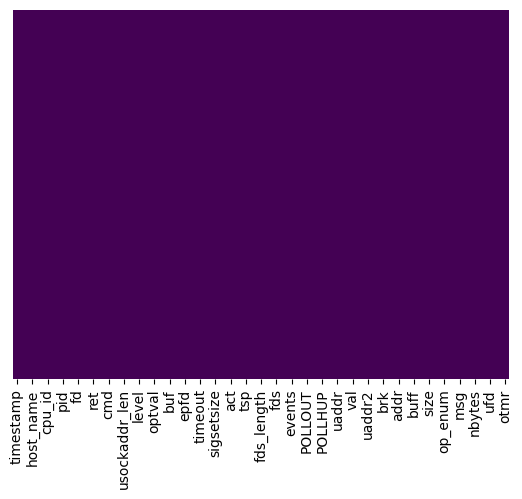

In [157]:
sns.heatmap(lstm.isnull(), yticklabels=False, cbar=False, cmap='viridis') # shows if any null value rows exists in the dataset

In [158]:
# Backup original categorical values for decoder fitting
original_categoricals = lstm[categorical_cols].copy()

In [161]:
original_categoricals.head()

,timestamp,host_name,event_name,procname,fds,events,op_enum,event
0,06:13:02.227908688,mendax,syscall_entry_accept,elasticsearch,missing,missing,missing,missing
1,06:13:02.227912438,mendax,syscall_exit_accept,elasticsearch,missing,missing,missing,missing
2,06:13:02.227914646,mendax,syscall_entry_fcntl,elasticsearch,missing,missing,missing,missing
3,06:13:02.227914980,mendax,syscall_exit_fcntl,elasticsearch,missing,missing,missing,missing
4,06:13:02.227916313,mendax,syscall_entry_getsockname,elasticsearch,missing,missing,missing,missing


In [162]:
# Encode categorical "event" type to integer
for col in categorical_cols:
    le = LabelEncoder()
    lstm[col] = le.fit_transform(lstm[col].astype(str))

# Normalize features
# scaler = MinMaxScaler()
# lstm[numerical_cols] = scaler.fit_transform(lstm[numerical_cols])

In [163]:
lstm.head(1000)

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,ubuf,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr
0,0,3.735000e-06,0,0,2,7,11822,11859,553,246916502706640,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
1,1,3.750000e-06,0,16,2,7,11822,11859,-1,246916502706640,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
2,112,2.208000e-06,0,43,2,7,11822,11859,576,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
3,223,3.340000e-07,0,24,2,7,11822,11859,-1,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
4,334,1.333000e-06,0,46,2,7,11822,11859,576,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,961,2.500000e-07,0,39,0,2,14323,14330,-1,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
966,962,2.090000e-07,0,42,0,2,14323,14330,35,-1,...,-1,1,0,-1,143360,-1,4,-1,-1,-1
967,963,8.330000e-07,0,22,0,2,14323,14330,35,-1,...,-1,1,0,-1,143360,-1,4,-1,-1,-1
968,964,3.330000e-07,0,3,0,2,14323,14330,34,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1


In [177]:
lstmData = lstm.copy(deep=True)

In [165]:
lstmData = lstmData.drop('timestamp', axis=1)

In [178]:
lstmData.head()

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,ubuf,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr
0,0,3.735000e-06,0,0,2,7,11822,11859,553,246916502706640,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
1,1,3.750000e-06,0,16,2,7,11822,11859,-1,246916502706640,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
2,112,2.208000e-06,0,43,2,7,11822,11859,576,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
3,223,3.340000e-07,0,24,2,7,11822,11859,-1,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1
4,334,1.333000e-06,0,46,2,7,11822,11859,576,-1,...,-1,1,0,-1,-1,-1,-1,-1,-1,-1


In [179]:
lstmData = lstmData.astype('float64')

In [180]:
lstmData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       970 non-null    float64
 1   time_elapsed    970 non-null    float64
 2   host_name       970 non-null    float64
 3   event_name      970 non-null    float64
 4   cpu_id          970 non-null    float64
 5   procname        970 non-null    float64
 6   pid             970 non-null    float64
 7   tid             970 non-null    float64
 8   fd              970 non-null    float64
 9   upeer_addrlen   970 non-null    float64
 10  ret             970 non-null    float64
 11  upeer_sockaddr  970 non-null    float64
 12  cmd             970 non-null    float64
 13  arg             970 non-null    float64
 14  usockaddr_len   970 non-null    float64
 15  usockaddr       970 non-null    float64
 16  level           970 non-null    float64
 17  optname         970 non-null    flo

In [181]:
lstmValue = lstmData.values
sequence_length = 35
# Creating training data using TimeSeriesGenerator
X, y = [], []
for i in range(len(lstmValue) - sequence_length):
    X.append(lstmValue[i:i + sequence_length])
    y.append(lstmValue[i + sequence_length])

X, y = np.array(X), np.array(y)

In [182]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(y.shape[1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [183]:
# Compile model
model.compile(optimizer="adam", loss="mse")

# Train the model
model.fit(X, y, epochs=30, batch_size=32)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 719107727124964669367779328.0000
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 723964902413524983984685056.0000
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 714658372454385925518000128.0000
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 722369185264172812931694592.0000
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 692506858087888842393649152.0000
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 718717984316175333961236480.0000
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 714173813381057723016151040.0000
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 714498771224660190477418496.0000
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 727592048807250345699835904.0000
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 709737592792259460367122432.0000
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 706685025582942003765706752.0

In [184]:
# Generate new sequence
def generate_synthetic_data(model, seed_data, num_steps=50):
    generated_data = list(seed_data)

    for _ in range(num_steps):
        input_seq = np.array(generated_data[-sequence_length:]).reshape(1, sequence_length, -1)
        predicted = model.predict(input_seq, verbose=0)[0]
        generated_data.append(predicted)

    return np.array(generated_data)

In [185]:
sequence_length = 35
seed_sequence = lstmValue[-sequence_length:]
encoders = {}
columns = lstmData.columns.tolist()

# Generate synthetic data
synthetic_logs = generate_synthetic_data(model, seed_sequence, num_steps=1000)
synthetic_df = pd.DataFrame(synthetic_logs, columns=columns)
subset_df = real_data

categorical_cols = [
    'timestamp', 'host_name', 'event_name', 'procname', 'fds', 'events', 'op_enum', 'event'
]

# Fit encoders explicitly on original strings
for col in categorical_cols:
    encoder = LabelEncoder()
    encoder.fit(subset_df[col].astype(str))
    encoders[col] = encoder

# Decode categorical columns explicitly
for col in categorical_cols:
    if col not in synthetic_df.columns:
        continue

    encoder = encoders[col]
    max_index = len(encoder.classes_) - 1

    # Convert entire column explicitly to int and clip BEFORE decoding
    synthetic_df[col] = synthetic_df[col].round().astype(int).clip(0, max_index)
    synthetic_df[col] = encoder.inverse_transform(synthetic_df[col])

# Ensure categorical columns dtype
synthetic_df[categorical_cols] = synthetic_df[categorical_cols].astype('object')

print("\n✅ Corrected Synthetic Logs (Categorical Columns Decoded):")
print(synthetic_df.head())


✅ Corrected Synthetic Logs (Categorical Columns Decoded):
            timestamp  time_elapsed host_name               event_name  \
0  06:13:02.232207990  1.250000e-07    mendax       syscall_exit_fcntl   
1  06:13:02.232208323  1.250000e-07    mendax  syscall_entry_epoll_ctl   
2  06:13:02.232233031  1.250000e-07    mendax       syscall_exit_fcntl   
3  06:13:02.232233281  1.660000e-07    mendax  syscall_entry_epoll_ctl   
4  06:13:02.232233406  1.250000e-07    mendax       syscall_exit_fcntl   

   cpu_id procname      pid      tid    fd  upeer_addrlen  ...  ubuf  op_enum  \
0     0.0     curl  14323.0  14330.0  -1.0           -1.0  ...  -1.0      nan   
1     0.0     curl  14323.0  14330.0  34.0           -1.0  ...  -1.0      nan   
2     0.0     curl  14323.0  14330.0  -1.0           -1.0  ...  -1.0      nan   
3     0.0     curl  14323.0  14330.0  34.0           -1.0  ...  -1.0      nan   
4     0.0     curl  14323.0  14330.0  -1.0           -1.0  ...  -1.0      nan   

   event 

In [186]:
lstmData.columns

Index(['timestamp', 'time_elapsed', 'host_name', 'event_name', 'cpu_id',
       'procname', 'pid', 'tid', 'fd', 'upeer_addrlen', 'ret',
       'upeer_sockaddr', 'cmd', 'arg', 'usockaddr_len', 'usockaddr', 'level',
       'optname', 'optval', 'optlen', 'buf', 'count', 'epfd', 'maxevents',
       'timeout', 'sigmask', 'sigsetsize', 'sig', 'act', 'oact', 'tsp', 'nfds',
       'fds_length', 'overflow', 'fds', 'raw_events', 'events', 'POLLPRI',
       'POLLOUT', 'POLLERR', 'POLLHUP', 'padding', 'uaddr', 'op', 'val',
       'utime', 'uaddr2', 'val3', 'brk', 'flags', 'addr', 'len', 'buff',
       'addr_len', 'size', 'ubuf', 'op_enum', 'event', 'msg', 'offset',
       'nbytes', 'advice', 'ufd', 'utmr', 'otmr'],
      dtype='object')

In [187]:
def generate_synthetic_data(model, seed_data, num_steps=2000, noise_scale=0.01):
    generated_data = list(seed_data)

    for _ in range(num_steps):
        # Get last sequence_length steps
        input_seq = np.array(generated_data[-sequence_length:]).reshape(1, sequence_length, -1)

        # Get model predictions
        predicted = model.predict(input_seq, verbose=0)[0]

        # Add controlled random noise
        noise = np.random.normal(0, noise_scale, size=predicted.shape)
        new_point = predicted + noise

        # Optional: Clip values if your data has known bounds
        # new_point = np.clip(new_point, min_values, max_values)

        generated_data.append(new_point)

    return np.array(generated_data)

In [188]:
sequence_length = 35
seed_sequence = lstmValue[-sequence_length:]
encoders = {}
columns = lstmData.columns.tolist()

# Generate synthetic data
# synthetic_logs = generate_synthetic_data(model, seed_sequence, num_steps=2000)

synthetic_logs = generate_synthetic_data(model, seed_sequence, num_steps=2000, noise_scale=0.02)
synthetic_df = pd.DataFrame(synthetic_logs, columns=columns)
subset_df = real_data

# Process each categorical column
for col in categorical_cols:
    if col not in synthetic_df.columns:
        print(f"Warning: Column '{col}' not found in synthetic data")
        continue

    # Initialize and fit label encoder for this column
    encoder = LabelEncoder()

    # Handle NaN values in the training data
    clean_data = subset_df[col].fillna('NaN').astype(str)
    encoder.fit(clean_data)

    # Process synthetic data
    try:
        # Convert to int and clip to valid range
        col_data = synthetic_df[col].fillna(0).round().astype(int)
        max_valid_index = len(encoder.classes_) - 1
        col_data_clipped = col_data.clip(0, max_valid_index)

        # Inverse transform (decode) the values
        synthetic_df[col] = encoder.inverse_transform(col_data_clipped)

        # Replace 'NaN' strings with actual NaN
        synthetic_df[col] = synthetic_df[col].replace('NaN', np.nan)
    except Exception as e:
        print(f"Error processing column '{col}': {e}")
        # Keep original values if decoding fails
        continue

# Ensure proper data types
synthetic_df[categorical_cols] = synthetic_df[categorical_cols].astype('object')

print("\n✅ Final Synthetic Data with All Categorical Columns Decoded:")
print(synthetic_df.head())


✅ Final Synthetic Data with All Categorical Columns Decoded:
            timestamp  time_elapsed host_name               event_name  \
0  06:13:02.232207990  1.250000e-07    mendax       syscall_exit_fcntl   
1  06:13:02.232208323  1.250000e-07    mendax  syscall_entry_epoll_ctl   
2  06:13:02.232233031  1.250000e-07    mendax       syscall_exit_fcntl   
3  06:13:02.232233281  1.660000e-07    mendax  syscall_entry_epoll_ctl   
4  06:13:02.232233406  1.250000e-07    mendax       syscall_exit_fcntl   

   cpu_id procname      pid      tid    fd  upeer_addrlen  ...  ubuf  op_enum  \
0     0.0     curl  14323.0  14330.0  -1.0           -1.0  ...  -1.0      NaN   
1     0.0     curl  14323.0  14330.0  34.0           -1.0  ...  -1.0      NaN   
2     0.0     curl  14323.0  14330.0  -1.0           -1.0  ...  -1.0      NaN   
3     0.0     curl  14323.0  14330.0  34.0           -1.0  ...  -1.0      NaN   
4     0.0     curl  14323.0  14330.0  -1.0           -1.0  ...  -1.0      NaN   

   eve

<ipython-input-188-13b91fc0be20>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  synthetic_df[col] = synthetic_df[col].replace('NaN', np.nan)
<ipython-input-188-13b91fc0be20>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  synthetic_df[col] = synthetic_df[col].replace('NaN', np.nan)
<ipython-input-188-13b91fc0be20>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

In [194]:
synthetic_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,pid,tid,fd,upeer_addrlen,...,ubuf,op_enum,event,msg,offset,nbytes,advice,ufd,utmr,otmr
0,06:13:02.232207990,1.250000e-07,mendax,syscall_exit_fcntl,0.000000,curl,14323.000000,14330.000000,-1.000000,-1.000000,...,-1.000000,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,06:13:02.232208323,1.250000e-07,mendax,syscall_entry_epoll_ctl,0.000000,curl,14323.000000,14330.000000,34.000000,-1.000000,...,-1.000000,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,06:13:02.232233031,1.250000e-07,mendax,syscall_exit_fcntl,0.000000,curl,14323.000000,14330.000000,-1.000000,-1.000000,...,-1.000000,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,06:13:02.232233281,1.660000e-07,mendax,syscall_entry_epoll_ctl,0.000000,curl,14323.000000,14330.000000,34.000000,-1.000000,...,-1.000000,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,06:13:02.232233406,1.250000e-07,mendax,syscall_exit_fcntl,0.000000,curl,14323.000000,14330.000000,-1.000000,-1.000000,...,-1.000000,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,06:13:02.231234224,-1.464199e-01,mendax,syscall_exit_brk,0.949827,data-loop.0,3820.735122,3924.121423,822.716962,-0.965466,...,980.266657,NaN,NaN,611.234309,3377.384217,347.185139,-1.209552,-1.315969,542.831393,-0.764071
2031,06:13:02.231234224,-2.022139e-01,mendax,syscall_exit_brk,0.870294,data-loop.0,3820.741608,3924.118884,822.695710,-0.966078,...,980.247479,NaN,NaN,611.270665,3377.405473,347.168803,-1.230909,-1.302109,542.827916,-0.750241
2032,06:13:02.231234224,-1.915066e-01,mendax,syscall_exit_brk,0.890388,data-loop.0,3820.775500,3924.137575,822.703842,-0.954282,...,980.225924,NaN,NaN,611.235921,3377.443714,347.172144,-1.208319,-1.256263,542.837474,-0.744134
2033,06:13:02.231234224,-2.161201e-01,mendax,syscall_exit_brk,0.891010,data-loop.0,3820.779391,3924.130331,822.684171,-0.961438,...,980.211046,NaN,NaN,611.239093,3377.438604,347.205749,-1.206530,-1.242886,542.872539,-0.721748


In [191]:
print("Unique values in 'event':", synthetic_df['event_name'].unique())

Unique values in 'event': ['syscall_exit_fcntl' 'syscall_entry_epoll_ctl' 'syscall_entry_recvfrom'
 'syscall_exit_rt_sigaction' 'syscall_entry_ppoll' 'syscall_exit_read'
 'syscall_exit_sendto' 'syscall_entry_write' 'syscall_exit_brk']


In [192]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       2035 non-null   object 
 1   time_elapsed    2035 non-null   float64
 2   host_name       2035 non-null   object 
 3   event_name      2035 non-null   object 
 4   cpu_id          2035 non-null   float64
 5   procname        2035 non-null   object 
 6   pid             2035 non-null   float64
 7   tid             2035 non-null   float64
 8   fd              2035 non-null   float64
 9   upeer_addrlen   2035 non-null   float64
 10  ret             2035 non-null   float64
 11  upeer_sockaddr  2035 non-null   float64
 12  cmd             2035 non-null   float64
 13  arg             2035 non-null   float64
 14  usockaddr_len   2035 non-null   float64
 15  usockaddr       2035 non-null   float64
 16  level           2035 non-null   float64
 17  optname         2035 non-null   f

In [199]:
from datetime import datetime, timedelta
import random
import pandas as pd
import numpy as np

# Base timestamp and host
base_time = datetime.now()
hostname = "mendax"

# Block fields
second_block_fields = ['procname', 'pid', 'tid']
third_block_fields = [
    'fd', 'upeer_addrlen', 'ret', 'upeer_sockaddr', 'cmd', 'arg', 'usockaddr_len',
    'usockaddr', 'level', 'optname', 'optval', 'optlen', 'buf', 'count', 'epfd', 'maxevents', 'timeout', 'sigmask',
    'sigsetsize', 'sig', 'act', 'oact', 'tsp', 'nfds', 'fds_length', 'overflow', 'raw_events', 'POLLPRI', 'POLLOUT',
    'POLLERR', 'POLLHUP', 'padding', 'uaddr', 'op', 'val', 'utime', 'uaddr2', 'val3', 'brk', 'flags', 'addr', 'len', 'buff',
    'addr_len', 'size', 'ubuf', 'msg', 'offset', 'nbytes', 'advice', 'ufd', 'utmr', 'otmr'
]

# Define special fields (you can modify this list)
allow_negative_fields = []  # e.g., ['ret'] if you want to allow negative return codes

log_lines = []

for i, row in synthetic_df.iterrows():
    # Format timestamp
    timestamp = (base_time + timedelta(microseconds=i * 50)).strftime('%H:%M:%S.%f')[:-3]
    delta = f"+0.{random.randint(100000, 999999):09d}"

    event_name = row["event_name"]
    cpu_id = int(row["cpu_id"]) if "cpu_id" in row else 0

    # First block
    first_block = f"{{ cpu_id = {cpu_id} }}"

    # Second block
    second_parts = []
    for field in second_block_fields:
        if field not in row or pd.isna(row[field]):
            continue
        val = row[field]
        if isinstance(val, (int, float)) and val < 0 and field not in allow_negative_fields:
            continue
        val_str = f'"{val}"' if isinstance(val, str) else int(val)
        second_parts.append(f"{field} = {val_str}")
    second_block = f"{{ {', '.join(second_parts)} }}" if second_parts else "{}"

    # Third block
    third_parts = []
    for field in third_block_fields:
        if field not in row or pd.isna(row[field]):
            continue
        val = row[field]
        if isinstance(val, (int, float)) and val < 0 and field not in allow_negative_fields:
            continue
        val_str = f'"{val}"' if isinstance(val, str) else int(val)
        third_parts.append(f"{field} = {val_str}")
    third_block = f"{{ {', '.join(third_parts)} }}" if third_parts else "{}"

    # Final log line
    log_line = f"[{timestamp}] ({delta}) {hostname} {event_name}: {first_block}, {second_block}, {third_block}"
    log_lines.append(log_line)

# Print samples
print("\n📝 Sample LTTng-Style Logs:\n")
for line in log_lines:
    print(line)

# Save only the first 1000 lines to file
with open("synthetic_data_lstm_1K.txt", "w") as f:
    f.write("\n".join(log_lines[:1000]))

print("\n✅ Precise LTTng-style logs saved to 'synthetic_lttng_formatted_precise.log'")


📝 Sample LTTng-Style Logs:

[03:46:45.928] (+0.000123178) mendax syscall_exit_fcntl: { cpu_id = 0 }, { procname = "curl", pid = 14323, tid = 14330 }, { ret = 0, arg = 275115444656760 }
[03:46:45.928] (+0.000844226) mendax syscall_entry_epoll_ctl: { cpu_id = 0 }, { procname = "curl", pid = 14323, tid = 14330 }, { fd = 34, cmd = 2148070925, arg = 275115444656768 }
[03:46:45.928] (+0.000675907) mendax syscall_exit_fcntl: { cpu_id = 0 }, { procname = "curl", pid = 14323, tid = 14330 }, { ret = 0, arg = 275115444656768 }
[03:46:45.928] (+0.000579098) mendax syscall_entry_epoll_ctl: { cpu_id = 0 }, { procname = "curl", pid = 14323, tid = 14330 }, { fd = 34, cmd = 2148070923, arg = 275115444656688 }
[03:46:45.929] (+0.000724858) mendax syscall_exit_fcntl: { cpu_id = 0 }, { procname = "curl", pid = 14323, tid = 14330 }, { ret = 0, arg = 275115444656688 }
[03:46:45.929] (+0.000150171) mendax syscall_entry_recvfrom: { cpu_id = 0 }, { procname = "curl", pid = 14323, tid = 14330 }, { fd = 35, buf

In [ ]:
def evaluate_synthetic_data(original_df, synthetic_df, categorical_cols):
    """
    Robust statistical evaluation of synthetic data quality
    with proper handling of numerical vs categorical variables
    """
    results = {}

    # Create working copies to avoid modifying originals
    orig_df = original_df.copy()
    synth_df = synthetic_df.copy()

    # 1. Basic Descriptive Statistics Comparison
    print("\n📊 Descriptive Statistics Comparison:")
    print("Original Data:")
    print(orig_df.describe(include='all'))
    print("\nSynthetic Data:")
    print(synth_df.describe(include='all'))

    # 2. Separate numerical and categorical columns
    numerical_cols = [col for col in orig_df.select_dtypes(include=['float64', 'int64']).columns
                     if col not in categorical_cols and col in synth_df.columns]

    available_categorical = [col for col in categorical_cols
                           if col in orig_df.columns and col in synth_df.columns]

    # 3. Numerical Features Analysis
    if numerical_cols:
        print("\n🔢 Numerical Features Analysis:")

        # Distribution Comparison
        plt.figure(figsize=(15, 5*len(numerical_cols)))
        for i, col in enumerate(numerical_cols, 1):
            plt.subplot(len(numerical_cols), 1, i)
            sns.kdeplot(orig_df[col].dropna(), label='Original', color='blue')
            sns.kdeplot(synth_df[col].dropna(), label='Synthetic', color='orange')
            plt.title(f'Distribution Comparison: {col}')
            plt.legend()
        plt.tight_layout()
        plt.show()

        # KS Test
        results['ks_tests'] = {}
        for col in numerical_cols:
            try:
                ks_stat, p_value = stats.ks_2samp(
                    orig_df[col].dropna(),
                    synth_df[col].dropna()
                )
                results['ks_tests'][col] = {
                    'statistic': ks_stat,
                    'p_value': p_value,
                    'similar': p_value > 0.05
                }
            except Exception as e:
                print(f"Could not perform KS test for {col}: {str(e)}")
                results['ks_tests'][col] = None

        # Correlation Matrix
        print("\n🔷 Correlation Matrix Comparison:")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        sns.heatmap(orig_df[numerical_cols].corr(), annot=True, ax=ax1)
        ax1.set_title('Original Data Correlations')
        sns.heatmap(synth_df[numerical_cols].corr(), annot=True, ax=ax2)
        ax2.set_title('Synthetic Data Correlations')
        plt.show()

    # 4. Categorical Features Analysis
    if available_categorical:
        print("\n🔤 Categorical Features Analysis:")
        results['categorical_comparison'] = {}

        for col in available_categorical:
            try:
                # Calculate value counts
                orig_counts = orig_df[col].value_counts(normalize=True)
                synth_counts = synth_df[col].value_counts(normalize=True)

                # Align categories
                all_categories = list(set(orig_counts.index) | set(synth_counts.index))
                orig_counts = orig_counts.reindex(all_categories, fill_value=0)
                synth_counts = synth_counts.reindex(all_categories, fill_value=0)

                # Calculate JS divergence
                js_div = jensen_shannon_divergence(orig_counts, synth_counts)

                results['categorical_comparison'][col] = {
                    'original_dist': orig_counts.to_dict(),
                    'synthetic_dist': synth_counts.to_dict(),
                    'js_divergence': js_div,
                    'similar': js_div < 0.1
                }

                # Plot comparison
                plt.figure(figsize=(10, 5))
                width = 0.35
                x = np.arange(len(all_categories))

                plt.bar(x - width/2, orig_counts, width, label='Original')
                plt.bar(x + width/2, synth_counts, width, label='Synthetic')

                plt.xlabel('Categories')
                plt.ylabel('Proportion')
                plt.title(f'Distribution Comparison: {col}')
                plt.xticks(x, all_categories, rotation=45)
                plt.legend()
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Could not analyze categorical column {col}: {str(e)}")
                results['categorical_comparison'][col] = None

    # 5. Mutual Information Analysis
    results['mutual_information'] = {}
    if 'event' in orig_df.columns and 'event' in synth_df.columns:
        print("\n🔗 Mutual Information with 'event':")

        # For numerical features
        for col in numerical_cols[:5]:  # Limit to top 5
            try:
                mi_orig = mutual_info_score(
                    orig_df[col].round().fillna(0),
                    orig_df['event'].astype('category').cat.codes
                )
                mi_synth = mutual_info_score(
                    synth_df[col].round().fillna(0),
                    synth_df['event'].astype('category').cat.codes
                )
                results['mutual_information'][f"num_{col}"] = {
                    'original': mi_orig,
                    'synthetic': mi_synth,
                    'difference': abs(mi_orig - mi_synth)
                }
            except Exception as e:
                print(f"Could not calculate MI for numerical {col}: {str(e)}")

        # For categorical features
        for col in available_categorical[:5]:  # Limit to top 5
            try:
                mi_orig = mutual_info_score(
                    orig_df[col].astype('category').cat.codes,
                    orig_df['event'].astype('category').cat.codes
                )
                mi_synth = mutual_info_score(
                    synth_df[col].astype('category').cat.codes,
                    synth_df['event'].astype('category').cat.codes
                )
                results['mutual_information'][f"cat_{col}"] = {
                    'original': mi_orig,
                    'synthetic': mi_synth,
                    'difference': abs(mi_orig - mi_synth)
                }
            except Exception as e:
                print(f"Could not calculate MI for categorical {col}: {str(e)}")

    return results



In [ ]:
stat_df = lstm.copy(deep=True)
stat_df.drop(columns=['timestamp'], inplace=True)
stat_df = stat_df[:100000]


📊 Descriptive Statistics Comparison:
Original Data:
                event  cpu_id    prio  target_cpu       tid           comm  \
count   100000.000000  100000  100000    100000.0  100000.0  100000.000000   
unique            NaN       4       7         5.0     145.0            NaN   
top               NaN       3      20        -1.0      -1.0            NaN   
freq              NaN   35102   51330     45284.0   45272.0            NaN   
mean         3.820310     NaN     NaN         NaN       NaN      89.199920   
std          0.834283     NaN     NaN         NaN       NaN      30.028801   
min          0.000000     NaN     NaN         NaN       NaN       0.000000   
25%          3.000000     NaN     NaN         NaN       NaN      83.000000   
50%          4.000000     NaN     NaN         NaN       NaN      86.000000   
75%          5.000000     NaN     NaN         NaN       NaN     114.000000   
max          5.000000     NaN     NaN         NaN       NaN     114.000000   

        pr

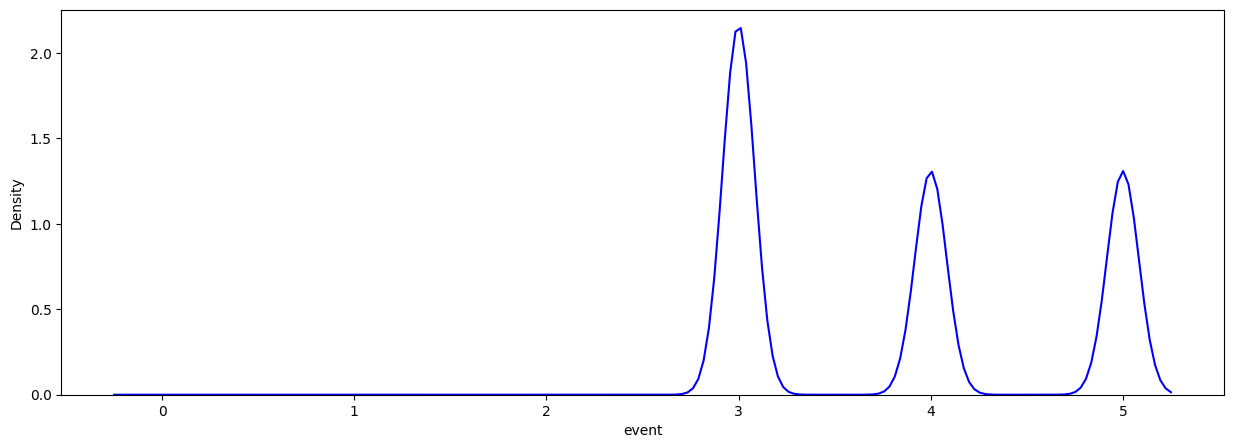

In [ ]:
# Run evaluation with error handling
try:
    evaluation_results = evaluate_synthetic_data(stat_df, synthetic_df, categorical_cols)

    # Print key results
    print("\n📈 Key Evaluation Metrics:")
    if 'ks_tests' in evaluation_results:
        print(f"KS Test Results (p-values > 0.05 indicate similar distributions):")
        for col, res in evaluation_results['ks_tests'].items():
            if res is not None:
                print(f"{col}: p-value={res['p_value']:.4f} ({'Similar' if res['similar'] else 'Different'})")

    if 'categorical_comparison' in evaluation_results:
        print("\n📊 Categorical Distribution Similarity (JS Divergence < 0.1 is good):")
        for col, res in evaluation_results['categorical_comparison'].items():
            if res is not None:
                print(f"{col}: JS Divergence={res['js_divergence']:.4f} ({'Similar' if res['similar'] else 'Different'})")

    if 'mutual_information' in evaluation_results:
        print("\n🔗 Mutual Information Preservation:")
        for col, res in evaluation_results['mutual_information'].items():
            if res is not None:
                print(f"{col}: Original MI={res['original']:.4f}, Synthetic MI={res['synthetic']:.4f}, Diff={res['difference']:.4f}")

except Exception as e:
    print(f"Evaluation failed: {str(e)}")

In [ ]:
y = lstmData['event']

In [ ]:
y = np.array(y)

In [ ]:
lstmRawData = lstmData.drop(['event', 'timestamp'], axis=1)

In [ ]:
lstmData = lstmRawData.values

In [ ]:
sequence_length = 10  # use last 10 timesteps

generator = TimeseriesGenerator(
    data=lstmData,
    targets=y,
    length=sequence_length,
    batch_size=32
)


In [ ]:


model = Sequential([
    LSTM(64, input_shape=(sequence_length, lstmData.shape[1])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # classification
])

X_train, X_val, y_train, y_val = train_test_split(lstmData, y, test_size=0.2, shuffle=False)

# Create two generators
train_gen = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=32)
val_gen = TimeseriesGenerator(X_val, y_val, length=sequence_length, batch_size=32)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 64)                  │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,294 (94.90 KB)

 Trainable params: 24,294 (94.90 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - accuracy: 0.5731 - loss: 0.9109 - val_accuracy: 0.6853 - val_loss: 0.7284
Epoch 2/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.6691 - loss: 0.7560 - val_accuracy: 0.6965 - val_loss: 0.7076
Epoch 3/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.6869 - loss: 0.7235 - val_accuracy: 0.7194 - val_loss: 0.6690
Epoch 4/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.6954 - loss: 0.7077 - val_accuracy: 0.7138 - val_loss: 0.6789
Epoch 5/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.7017 - loss: 0.6992 - val_accuracy: 0.7163 - val_loss: 0.6606
Epoch 6/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.7068 - loss: 0.6883 - val_accuracy: 0.7202 - val_loss: 0.6609
Epoch 7/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.7092 - loss: 0.6811 - val_accuracy: 0.7277 - val_loss: 0.6442
Epoch 8/10
11044/11044 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 

In [ ]:
# Use the last sequence from validation data as the seed
seed_idx = -1
seed_seq = X_val[seed_idx - sequence_length:seed_idx]  # shape: (sequence_length, features)
generated_sequence = list(seed_seq)

In [ ]:
num_future_steps = 500  # how many synthetic steps to generate
predicted_events = []

current_seq = seed_seq.copy()

for _ in range(num_future_steps):
    input_seq = current_seq.reshape(1, sequence_length, -1)
    pred = model.predict(input_seq, verbose=0)

    next_event_class = np.argmax(pred[0])
    predicted_events.append(next_event_class)

    synthetic_step = current_seq[-1].copy()
    synthetic_step[0] = next_event_class  # update the 'event' feature (assumed first)

    current_seq = np.vstack([current_seq[1:], synthetic_step])
    generated_sequence.append(synthetic_step)

In [ ]:
synthetic_array = np.array(generated_sequence)
synthetic_df = pd.DataFrame(synthetic_array, columns=lstmRawData.columns)

In [ ]:
synthetic_df = pd.DataFrame(generated_sequence[-num_future_steps:], columns=lstmRawData.columns)
synthetic_df['event'] = predicted_events

In [ ]:
# Decode event labels using original LabelEncoder
event_encoder = LabelEncoder()
event_encoder.fit(lstm['event'].astype(str))  # use original dataset to fit
synthetic_df['event'] = event_encoder.inverse_transform(synthetic_df['event'].astype(int))

In [ ]:
synthetic_df['event'].value_counts()

,count
event,
3,500


In [ ]:
event_encoder = LabelEncoder()
event_encoder.fit(df['event'].astype(str))

# Mapping of event name → integer
event_mapping = dict(zip(event_encoder.classes_, event_encoder.transform(event_encoder.classes_)))

# OR: reverse mapping (integer → event name)
reverse_event_mapping = dict(enumerate(event_encoder.classes_))

# Print nicely
print("Event Name → Encoded Integer:")
for name, code in event_mapping.items():
    print(f"{name} → {code}")

Event Name → Encoded Integer:
sched_process_exit → 0
sched_process_fork → 1
sched_process_free → 2
sched_switch → 3
sched_wakeup → 4
sched_waking → 5


In [ ]:
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col].astype(str))  # Fit on encoded data assuming it still has all original mappings
    encoders[col] = le

In [ ]:
for col in categorical_cols:
    if col in synthetic_df.columns:
        synthetic_df[col] = synthetic_df[col].astype(int)
        synthetic_df[col] = encoders[col].inverse_transform(synthetic_df[col])

In [ ]:
synthetic_df.head(50)

,target_cpu,cpu_id,comm,tid,prio,next_prio,next_tid,prev_prio,prev_tid,next_comm,...,parent_tid,parent_comm,child_ns_inum,child_pid,child_tid,child_comm,parent_ns_inum,_vtids_length,parent_pid,event
0,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
1,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
2,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
3,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
4,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
5,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
6,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
7,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
8,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
9,3.0,1.0,None,0.0,0.719424,0.863309,1.0,0.863309,0.089622,"""lttng""",...,0.0,None,0.0,0.0,0.0,None,0.0,0.0,0.0,sched_switch
